## Gaussian Process & Bayesian Optimization

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp

from matplotlib import animation
from matplotlib.animation import FuncAnimation


import warnings
warnings.filterwarnings('ignore')

In [47]:
def black_box_func(x, func): 
    
    if np.random.rand() < 0.9:
        out = func(x)  + np.random.randn() * 0.1
    
    else:
        out = np.random.rand() * 3
    
    return out


def random_func(x):
    out = -x * np.sin(x) - x * np.cos(x) 
    return out


def ackley_func(x, y=0):
    out = (-20*np.exp(-0.2*np.sqrt(0.5*(x**2 + y**2))) 
               - np.exp(0.5*(np.cos(2*np.pi*x) + np.cos(2*np.pi*y)))
               + np.e + 20)
    return out

In [48]:
def plot(X, Y, x_observed, y_observed, y_mean, y_std, legend=False):
    plt.close('all')
    plt.plot(X, Y, 'k--', linewidth=2, label='Actual function')
    plt.plot(x_observed, y_observed, 'bo', label="""Random samples of the function""", alpha=0.7)
    plt.plot(X, y_mean, 'r', linewidth=2, label='Gaussian process mean', alpha=0.7)
    plt.fill_between(X, y_mean - y_std, y_mean + y_std, alpha=0.2, color='r')
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')

    if legend == True:
        plt.legend()
    plt.show()

In [49]:
class Imitation:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.min_x = []

In [50]:
class Policy:
    
    def __init__(self, func, linspace_x_min, linspace_x_max, linspace_n_sample, exploit_constant, epoch, policy):
        
        self.X = np.linspace(linspace_x_min, linspace_x_max, linspace_n_sample)
        self.Y = func(self.X)
        self.func = func
        self.optima_x = self.X[np.argmin(self.Y)]
        self.exploit_constant = exploit_constant
        self.epoch = epoch
        self.means = []
        self.std_devs = []
        
        
        def ucb(gpr, y_mean, y_std):
            next_point = np.argmin(y_mean - self.exploit_constant * (y_std))
            return next_point
        
    
        def thompson_sampling(gpr, y_mean, y_std):
            y_sample = gpr.sample_y(self.X.reshape(-1,1))
            next_point = np.argmin(y_sample)

            return next_point

    
        def epsilon_greedy(gpr, y_mean, y_std):
            if np.random.rand() < (1 - self.exploit_constant):
                next_point =  np.argmin(y_mean)
            else:
                next_point = np.random.randint(0, len(self.X))

            return next_point
        
        if policy == "ucb":
            self.policy = ucb
        elif policy == "thompson_sampling":
            self.policy = thompson_sampling
        elif policy == "epsilon_greedy":
            self.policy = epsilon_greedy
        
    
        
    def optimize(self, observed, kernel):
        
        if kernel == 'Matern':
            K = 1.0 * gp.kernels.Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
        elif kernel == 'RBF':
            K = gp.kernels.RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
        elif kernel == "RationalQuadratic":
            K = gp.kernels.RationalQuadratic(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
        elif kernel == "ExpSineSquared":
            K = gp.kernels.ExpSineSquared(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
        else:
            raise Exception('Given kernel name is not valid.')
        
        
        gpr = gp.GaussianProcessRegressor(kernel=K)
        
        for i in range(self.epoch + 1):
            
            gpr.fit(observed.x.reshape(-1,1), observed.y)
            y_mean, y_std = gpr.predict(self.X.reshape(-1,1), return_std=True)
            
            self.means.append(y_mean)
            self.std_devs.append(y_std)
            
            plot(self.X, self.Y, observed.x, observed.y, y_mean, y_std)
            
            if i != 0:
                print("selected x point: {}".format(observed.min_x[-1]))
                print("optima x: {}".format(self.optima_x))
            
            next_point = self.policy(gpr, y_mean, y_std)
            
            x_next = self.X[next_point]
            y_next = black_box_func(x_next, self.func)
            
            observed.x = np.append(observed.x, x_next)
            observed.y = np.append(observed.y, y_next)
            observed.min_x.append(x_next) 

In [57]:
func_name = ackley_func
linspace_min = -4
linspace_max = 4
n_training_samples = 4

x_observed = np.random.uniform(linspace_min, linspace_max, n_training_samples)
y_observed = func_name(x_observed)
observed = Imitation(x_observed, y_observed)

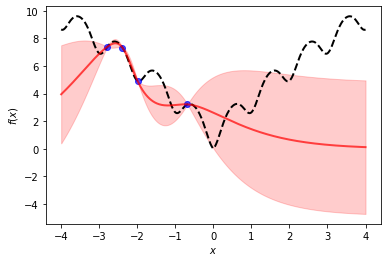

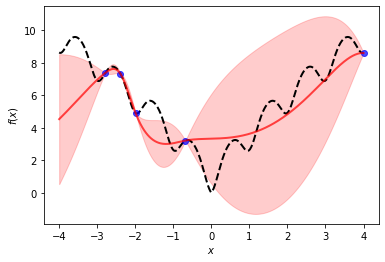

selected x point: 4.0
optima x: 0.00801603206412782


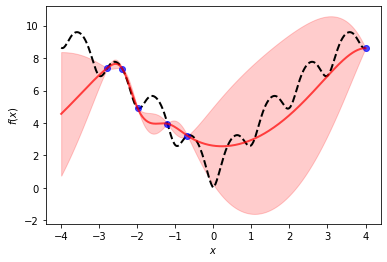

selected x point: -1.210420841683367
optima x: 0.00801603206412782


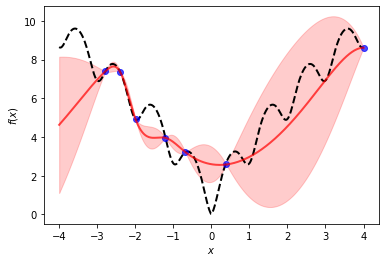

selected x point: 0.3927855711422845
optima x: 0.00801603206412782


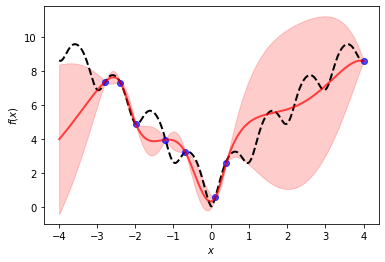

selected x point: 0.104208416833667
optima x: 0.00801603206412782


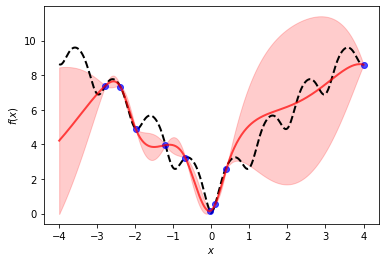

selected x point: -0.024048096192385238
optima x: 0.00801603206412782


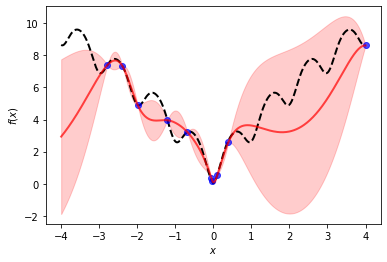

selected x point: -0.056112224448898296
optima x: 0.00801603206412782


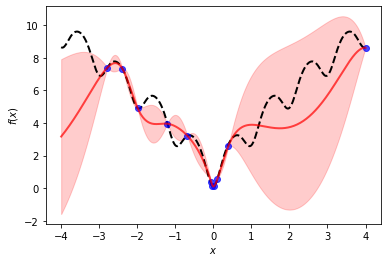

selected x point: 0.00801603206412782
optima x: 0.00801603206412782


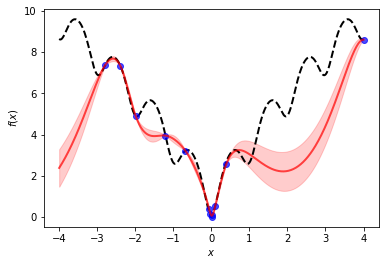

selected x point: 0.00801603206412782
optima x: 0.00801603206412782


In [58]:
%matplotlib inline

model = Policy(func=func_name, 
               linspace_x_min=linspace_min, 
               linspace_x_max=linspace_max, 
               linspace_n_sample=500, 
               exploit_constant=0.1, 
               epoch=8, 
               policy='ucb')

model.optimize(observed, kernel='Matern')

---

### Animate

In [64]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation
%matplotlib qt

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (15,5))

xdata = list(observed.x[: len(model.means) - 1])
ydata = list(observed.y[: len(model.means) - 1])

def update(frames):
    axes.clear()
    axes.set_ylim(-15, 15)
    axes.set_xlim(-4, 4)
    
    xdata.append(observed.x[n_training_samples + frames])
    ydata.append(observed.y[n_training_samples + frames])
    
    axes.plot(model.X, model.Y, 'k--', linewidth=2, label='Actual function')
    axes.plot(observed.x[: n_training_samples + frames], observed.y[: n_training_samples + frames], 
              'bo', label="""Random samples of the function""", alpha=0.7)
    axes.plot(model.X, model.means[frames], 'r', linewidth=2, label='Gaussian process mean', alpha=0.7)
    axes.fill_between(model.X, model.means[frames] - model.std_devs[frames], model.means[frames] + model.std_devs[frames], 
                      alpha=0.2, color='r')
    if frames != 0:
        axes.axvline(x = observed.x[n_training_samples + frames - 1], label="Selected x point", linestyle="--")
    
    axes.legend()
    
anim = FuncAnimation(fig, update, np.arange(len(model.means)), interval=750, repeat=False)